Instrukcje
Zaimplementuj algorytm genetyczny z uwzględnieniem poniższych wymagań:   

kodowanie binarne bądź dyskretne/ciągłe genotypu   
parametryzacja długości genotypu, wielkości populacji   
krzyżowanie k-punktowe z prawdopodobieństwem pk, losowanie locusów bez zwracania   
mutacja m-punktowa z prawdopodobieństwem pm, losowanie locusów bez zwracania   
selekcja:   
rankingowa: n najlepszych osobników zastępuje w populacji n najgorszych   
koło ruletki z uwzględnieniem funkcji transformującej wartości funkcji przystosowania   
		warunek stopu: liczba pokoleń, opcjonalnie docelowa wartość funkcji przystosowania, % najlepszych osobników w populacji   
Użyj algorytmu do optymalizacji ANFIS.  

# Upload of libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import math
import random
import time
import copy
from params import FuzzyInputVariable_3Trapezoids, FuzzyInputVariable_2Trapezoids, FuzzyInputVariable_List_Trapezoids
from ANFIS import ANFIS
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
from typing import List, Tuple, Callable
from tqdm import tqdm
from helps_and_enhancers import calculate_combinations, my_reshape
from operators import productN, zadeh_t
from goal_function_object import *

# Create a GA class

In [2]:
class GeneticAlgorithm:
    """
    A genetic algorithm implementation.
    """
    def __init__(self,
        fitness_func: Callable[[np.ndarray], float],
        genotype_length: int,
        population_size: int = 100,
        gene_type: str = "continious",
        bounds: tuple[float, float] = (0.0, 1.0)
        ):
        """
        Initializes instances of class GeneticAlgorithm
        
        Args: 
            fitness_func (callable[[np.ndarray], float]): function accepting a genotype and return float score.
            genotype_length (int): Number of genes, parameters
            population_size (int): Number of individuals (chromosomes) are in the population
            gene_type (str): Available 'continious', 'discrete', 'binary'
            bounds (min, max): Constraints for genes
            selection_method (str): The method used to select parent from the population
        """
        self.fitness_func = fitness_func
        self.genotype_length = genotype_length
        self.population_size = population_size
        self.gene_type = gene_type
        self.bounds = bounds

        # State
        self.population: np.ndarray = None
        self.fitness_scores: np.ndarray = None
        self.best_individual = None
        self.best_fitness = -np.inf
        
        self._create_initial_population()

    
    def _create_initial_population(self):
        low, high = self.bounds

        # Generate the initial population based on gene type

        if self.gene_type == 'continious':
            self.population = np.random.uniform(low, high, size=(self.population_size, self.genotype_length))
        elif self.gene_type == 'binary':
            self.population = np.random.binomial(n=1, p=0.5, size=(self.population_size, self.genotype_length))
        elif self.gene_type == 'discrete':
            self.population = np.random.randint(low, high + 1, size=(self.population, self.genotype_length))
        else:
            raise ValueError(f"Uknown gene type {self.gene_type}")
        
        # Initial evaluation
        self.fitness_scores = np.array([self.fitness_func(ind) for ind in self.population])
        self._update_best()


    def _update_best(self):
        """Updates the global best solution found so far"""
        max_idx = np.argmax(self.fitness_scores)
        if self.fitness_scores[max_idx] > self.best_fitness:
            self.best_fitness = self.fitness_scores[max_idx]
            self.best_individual = self.population[max_idx].copy()

    
    def _crossover_k_point(self, parent1: np.ndarray, parent2: np.ndarray, k: int, prob_pk: float) -> Tuple[np.ndarray, np.ndarray]:
        """
        Performs Order Crossover

        Args:
            k (int): Number of cut points
            prob_pk (float): Probability of crossover happens
        """
        if random.random() >= prob_pk:
            return parent1.copy(), parent2.copy()
        
        # Draw indices without returning
        cut_points = sorted(random.sample(range(1, self.genotype_length), k))

        child1 = parent1.copy()
        child2 = parent2.copy()

        # Swap segments between cut points
        swap = False
        start = 0

        # Add end of array as a virtual cut point
        extended_cuts = cut_points + [self.genotype_length]

        for cut in extended_cuts:
            if swap:
                child1[start:cut], child2[start:cut] = parent2[start:cut].copy(), parent1[start:cut].copy()
            # Changing a state of swap as opposite 
            swap = not swap
            start = cut
        
        return child1, child2

    def _mutation_m_points(self, individual: np.ndarray, m: int, prob_pm: float):
        """
        Performs Mutation in m points on a chromosome.

        Args:
            m (int): Number of genes to mutate
            prob_pm (float): Probabilit that mutations happens
        """

        if random.random() >= prob_pm:
            return
        
        # Select m indices to mutate
        mutation_indices = random.sample(range(self.genotype_length), m)
        low, high = self.bounds

        for idx in mutation_indices:
            if self.gene_type == 'continious':
                individual[idx] = random.uniform(low, high)
            elif self.gene_type == 'binary':
                individual[idx] = 1 - individual[idx]
            elif self.gene_type == 'discrete':
                individual[idx] = random.randint(low, high)

    
    def _selection_roulette(self, transformation_func: Callable[[float], float] = None) -> np.ndarray:
        """
        Selects one parent using Roulette Wheel Selection
        
        Notes:
        This function can use optional fitness transformation 
        """
        scores = self.fitness_scores

        # Trasnform 
        if transformation_func:
            adjusted_scores = np.array([transformation_func(s) for s in scores])
        else:
            adjusted_scores = scores.copy()
        
        # Handle cases with negative fitness by shifting
        if np.min(adjusted_scores) < 0:
            adjusted_scores = adjusted_scores - np.min(adjusted_scores) + 1e-6

        total = np.sum(adjusted_scores)

        if total == 0:
            probs = np.ones(len(scores)) / len(scores)
        else:
            probs = adjusted_scores / total

        # Selected parent
        chosen_idx = np.random.choice(len(self.population), p=probs)

        return self.population[chosen_idx]
    

    def _selection_rank(self, offspring: list[np.ndarray], n_replace: int):
        """Selects N best offspring using Rank Selection and replace N worst individuals"""

        # Calculate fitness or every offsrping 
        off_scores = np.array([self.fitness_func(ind) for ind in offspring])

        # Sort fitness of offsrping
        off_sorted_idx = np.argsort(off_scores)[::-1]

        # Sort population, from the smallest to biggest
        pop_sorted_idx = np.argsort(self.fitness_scores)

        # Replacement
        for i in range(n_replace):
            
            # If the offsrping is smaller than number of replacement
            if i >= len(offspring): break

            worst_pop_idx = pop_sorted_idx[i]
            best_off_idx = off_sorted_idx[i]

            # Elitism
            if off_scores[best_off_idx] > self.fitness_scores[worst_pop_idx]:
                self.population[worst_pop_idx] = offspring[best_off_idx]
                
                # Remember to change also fitnes score
                self.fitness_scores[worst_pop_idx] = off_scores[best_off_idx]


    def run(self, 
        num_generations: int,
        k_crossover: int = 1,
        pk_prob: float = 0.8,
        m_mutation: int = 1,
        pm_prob: float = 0.1,
        target_fitness: float = None,
        dominance_threshold: float = 0.9):
        """
        Run Genetic Algorithm

        Args:
            num_generations (int): Number of generations
            k_crossover (int): Number of crossover
            pk_prob (float): Probability that crossover happens.
            m_mutation (int): Number of mutations
            pm_prob (float): Probability that mutations happens
            target_fitness (float): Algorithm will stop if it will achieve the target fitness
            dominance_threshold (float): Algorithm will stopp if the given % of population will be close to best fitness

        Returns:
            best_individual
            best_fitness_score
        """

        for gen in tqdm(range(num_generations)):
            
            # First stop condition - goal function achieved
            if target_fitness is not None and self.best_fitness >= target_fitness:
                print(f"Goal fitness {target_fitness} reached at {gen} ")
                break

            # Second stop condition- Population dominance
            # Count how many individuals are very close to the best fitness
            matches = np.sum(np.isclose(self.fitness_scores, self.best_fitness, atol=1e-5))
            if matches / self.population_size >= dominance_threshold:
                print(f"Population dominance reached threshold {dominance_threshold} at gen {gen}")
                break
            
            # Create a poll of offspring
            offsrping_pool = []

            # Full batch
            pool_target_size = self.population_size
            
            while len(offsrping_pool) < pool_target_size:
                # roulette selecion, squaring for transformation function
                parent1 = self._selection_roulette(lambda x: x**2 if x > 0 else 0)
                parent2 = self._selection_roulette(lambda x: x**2 if x > 0 else 0)

                # Crossover
                crossover1, crossover2 = self._crossover_k_point(parent1, parent2, k=k_crossover, prob_pk=pk_prob)

                # Mutation
                self._mutation_m_points(crossover1, m=m_mutation, prob_pm=pm_prob)
                self._mutation_m_points(crossover2, m=m_mutation, prob_pm=pm_prob)

                offsrping_pool.extend([crossover1, crossover2])

            # Elitizm, replace 50% of worst parents with best children
            n_replace = int(self.population_size * 0.5)
            self._selection_rank(offsrping_pool, n_replace)

            # Update stats
            self._update_best()


        return self.best_individual, self.best_fitness

# Creating bridge between ANFIS and GA

In [3]:
class GA_ANFIS_Bridge:
    """
    Bridge between the GA and ANFIS.
    Stores the data and model structure, allowing the GA optimize blindly
    """

    def __init__(self, anfis):
        self.anfis = anfis

        # Premises (trapezoid params)
        flat_premises = np.array([p for sublist in anfis.premises for p in sublist]).flatten()

        # Operators
        flat_op = np.array(anfis.op)

        # Consequents
        flat_tsk = anfis.tsk.flatten()

        # Set split points
        self.idx_premises = len(flat_premises)
        self.idx_op = self.idx_premises + len(flat_op)
        self.total_genes = self.idx_op + len(flat_tsk)


    def _constrain_genes(self, genotype):
        """
        Apply logical constraints on parameters. Returns a copy of the genotype with corrected values
        """
        corrected = genotype.copy()

        for i in range(0, self.idx_premises, 2):
            # Our Trapezoids takes parameters [center, width] we wanna keep within data range (0, 1)
            # with some tolerance
            corrected[i] = np.clip(corrected[i], -0.2, 1.2)

            # Lets correct width, it has to be small and positive
            corrected[i+1] = np.clip(np.abs(corrected[i+1]), 0.01, 0.99)

        return corrected
    

    def fitness_function(self, genotype: np.ndarray) -> float:
        """
        This function will be used by Genetic Algorithm. 
        
        Args:
            genotype (np.ndarray): 1D array. 
        Output: 
            Fintess score (higher is better)
        """
        # Apply boundaries
        constained_genes = self._constrain_genes(genotype)

        # Extract premises
        raw_premises = constained_genes[:self.idx_premises]

        # Reshape to form which ANFIS expects (Input x MFs x Params)
        new_premises = raw_premises.reshape(np.shape(self.anfis.premises))

        # Extract operators
        new_op = genotype[self.idx_premises:self.idx_op]

        # Extract consequents
        raw_tsk = genotype[self.idx_op:]
        new_tsk = raw_tsk.reshape(np.shape(self.anfis.tsk))

        # Run ANFIS
        predictions = self.anfis.anfis_estimate_labels(new_premises, new_op, new_tsk)

        # Calculate error 
        error = np.sum(np.abs(predictions - self.anfis.expected_labels))

        # Maximize fitness but we wanna minimize the error so 1/ 1+ error
        return 1.0 / (1.0 + error)
    

    def get_genotype_length(self) -> int:
        """
        Calculates the total length of genes needed (Premises + Consequents)
        """
        return self.total_genes
    

    def update_model(self, best_genes):
        """Save the best genes into the ANFIS object"""
        # Apply boundaries
        constrained = self._constrain_genes(best_genes)

        # Extract premises
        raw_premises = constrained[:self.idx_premises]

        # Reshape to form which ANFIS expects (Input x MFs x Params)
        new_premises = raw_premises.reshape(np.shape(self.anfis.premises))
        
        # Set new premises
        self.anfis.set_premises_parameters(new_premises)

        # Extract operators
        new_op = best_genes[self.idx_premises:self.idx_op]

        # Set new operators
        self.anfis.op = new_op.tolist()

        # Extract consequents
        raw_tsk = best_genes[self.idx_op:]
        new_tsk = raw_tsk.reshape(np.shape(self.anfis.tsk))

        # Set new consequents
        self.anfis.tsk = new_tsk


# Using GA to solve ANFIS XOR problem 

## Prepare data for XOR


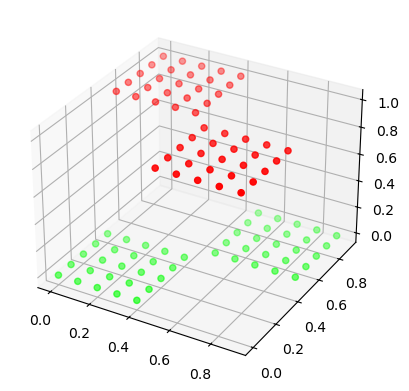

Parametry początkowe:
Przesłanki:  [[0.5, 0.5], [0.5, 0.5]] 
Konkluzje:  [[0.15700889 0.96681694 0.6142321 ]
 [0.73800815 0.69686629 0.8048742 ]
 [0.23307502 0.58438024 0.48270997]
 [0.84405637 0.03934467 0.29574924]]


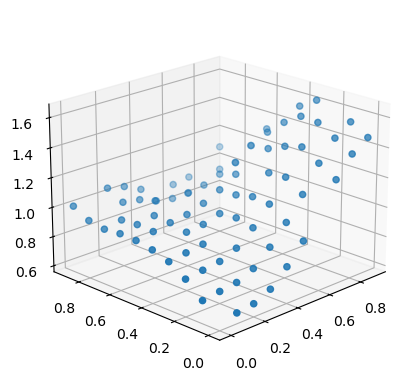

In [4]:
x = np.arange(0, 1, 0.1)
x,y = np.meshgrid(x, x)

dataX = x.flatten()
dataY = y.flatten()
dataXY1 = np.column_stack((dataX,dataY,np.ones(len(dataX))))
dataXY = np.column_stack((dataX,dataY))

data_labels = np.logical_xor(dataX >= 0.5, dataY >= 0.5) 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

rgb = [[1,0,0] if cc else [0,1,0] for cc in data_labels]

ax.scatter(dataX, dataY, data_labels, c=rgb)

plt.show()

varX = FuzzyInputVariable_2Trapezoids(0.5, 0.5, "XAxis", ["L","H"]) # low, high
varY = FuzzyInputVariable_2Trapezoids(0.5, 0.5, "YAxis", ["L","H"])

X_train, X_test, y_train, y_test = train_test_split(dataXY, data_labels, test_size=0.2, random_state=25)

fis = ANFIS([varX, varY], X_train.T, y_train, operator_function=zadeh_t)

print("Parametry początkowe:\nPrzesłanki: ",fis.premises, "\nKonkluzje: ", fis.tsk)

fis.show_results()

## Initialize the optimizer

In [5]:
bridge = GA_ANFIS_Bridge(fis)

# Get length
gene_len = bridge.get_genotype_length()
print(f"Genotype length is equal: {gene_len}")

Genotype length is equal: 20


## Configure GA

  6%|▌         | 58/1000 [00:02<00:39, 24.06it/s]


Population dominance reached threshold 0.9999 at gen 58


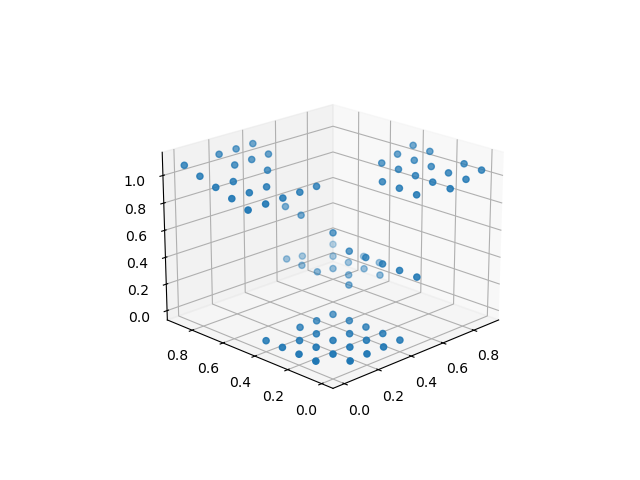

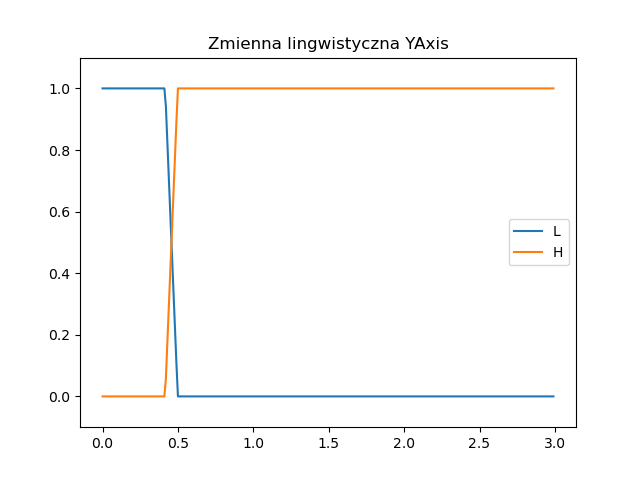

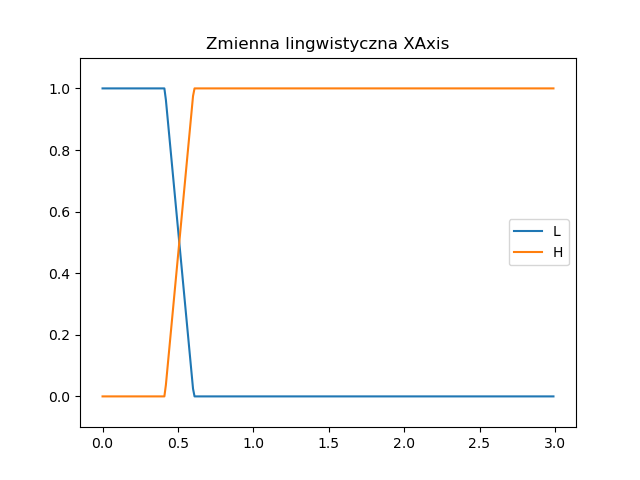

In [6]:
%matplotlib widget
ga_model = GeneticAlgorithm(
    fitness_func=bridge.fitness_function,
    genotype_length=gene_len,
    population_size=200,
    gene_type='continious',
    bounds=(0, 1),
)

# Run
best_genes, best_score = ga_model.run(
    num_generations=1000,
    k_crossover=4,
    pk_prob=0.8,
    m_mutation=5,
    pm_prob=0.1,
    dominance_threshold=0.9999
)

# Updates anfis with best result
bridge.update_model(best_genes)
fis.show_results()
plt.figure()
varX.show()
plt.legend()

plt.figure()
varY.show()
plt.legend()

plt.show()


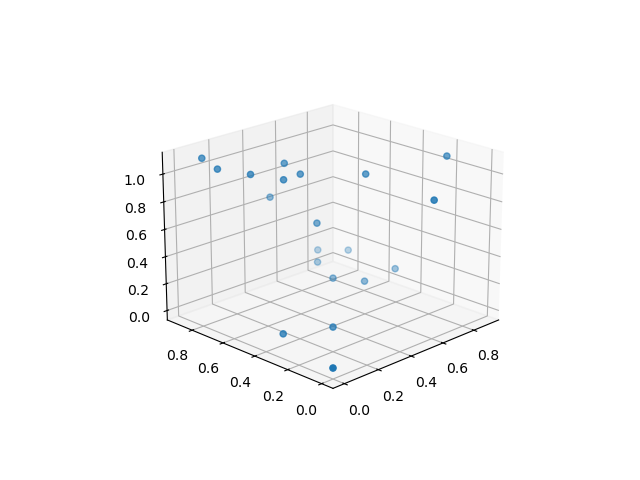

Parametry koncowe :
Przesłanki:  [[0.50882467 0.19189878]
 [0.45701662 0.08370072]] 
Konkluzje:  [[0.01889181 0.00818722 0.00712971]
 [0.29169376 0.09027659 0.77635488]
 [0.03638131 0.41719921 0.69794703]
 [0.04715932 0.06068491 0.0253322 ]]
[[9 2]
 [0 9]]


In [7]:
fis.training_data = X_test.T
fis.expected_labels = y_test
fis.show_results()
print("Parametry koncowe :\nPrzesłanki: ",fis.premises, "\nKonkluzje: ", fis.tsk)
y_pred = fis.anfis_estimate_labels(fis.premises,fis.op,fis.tsk)
y_pred = list(map(round,y_pred.flatten()))
print(confusion_matrix(y_test, y_pred))